<a href="https://colab.research.google.com/github/rohitamar/VAE/blob/main/GumbelSoftmaxVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Currently using device: {device}")

Currently using device: cuda


In [5]:
class GVAE(nn.Module):
    def __init__(self, num_cats, per_cat):
        super().__init__()
        self.num_cats = num_cats
        self.per_cat = per_cat

        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 400),
            nn.ReLU(),
            nn.Linear(400, num_cats * per_cat)
        )

        self.decoder = nn.Sequential(
            nn.Linear(num_cats * per_cat, 400),
            nn.ReLU(),
            nn.Linear(400, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def decode(self, x):
        return self.decoder(x)

    # knowledge check
    def gumbel_softmax(self, logits, tau):
        def gumbel(shape):
            eps = 1e-20
            u = torch.rand(shape)
            return -torch.log(-torch.log(u + eps) + eps).to(device)

        x = F.softmax(logits / tau + gumbel(logits.shape) / tau, dim=-1)
        ind = torch.argmax(x, dim=-1, keepdim=True)
        x_hard = torch.zeros_like(x).scatter_(-1, ind, 1)
        return (x_hard - x).detach() + x

    def forward(self, x, *, tau=1.0):
        z = self.encoder(x)
        z = z.reshape(-1, self.num_cats, self.per_cat)
        z_g = F.gumbel_softmax(z, tau=tau, hard=True)
        z_g = z_g.reshape(-1, self.num_cats * self.per_cat)
        return self.decode(z_g), F.softmax(z, dim=-1).reshape(-1, self.num_cats * self.per_cat)

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [7]:
from torch.optim import Adam

eps = 1e-8
def train_model(model, dataloader, config):
    epochs = config['epochs']
    optimizer = Adam(model.parameters(), lr=1e-3)

    avg_losses = []
    avg_recons = []
    avg_kls = []

    tau_max = config['tau_max']
    tau_min = config['tau_min']

    model = model.to(device)
    for epoch in range(epochs):
        avg_loss = avg_recon = avg_kl = 0.0
        iters = 0

        tau = tau_max - (epoch / epochs) * (tau_max - tau_min)

        for step, data in enumerate(dataloader):
            input, _ = data
            input = input.to(device)
            input = input.reshape(-1, 28 * 28)
            batch_size = input.size(0)

            preds, pi = model(input, tau=tau)

            recon = F.binary_cross_entropy(preds, input, reduction='sum') / batch_size
            kl = torch.sum(pi * torch.log(pi + eps), dim=-1).mean()
            loss = recon + kl

            avg_loss += loss.item()
            avg_recon += recon.item()
            avg_kl += kl.item()
            iters += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_loss /= iters
        avg_recon /= iters
        avg_kl /= iters

        print(f"Epoch {epoch} - Recon: {avg_recon} KL: {avg_kl} Both: {avg_loss}")
        avg_losses.append(avg_loss)
        avg_recons.append(avg_recon)
        avg_kls.append(avg_kl)

    return avg_losses, avg_recons, avg_kls

In [96]:
model = GVAE(20, 10).to(device)
loss, recon, kl = train_model(model, train_loader, {
    'epochs': 75,
    'tau_max': 1.0,
    'tau_min': 0.1
})

Epoch 0 - Recon: 167.17651785481772 KL: -38.88465673014323 Both: 128.2918610148112
Epoch 1 - Recon: 134.33478562825522 KL: -34.4216728902181 Both: 99.91311268717448
Epoch 2 - Recon: 124.1922347290039 KL: -33.04274497273763 Both: 91.14948981933594
Epoch 3 - Recon: 118.09121279703776 KL: -32.23964921468099 Both: 85.8515635538737
Epoch 4 - Recon: 114.21603598632812 KL: -31.701410214233398 Both: 82.51462575276693
Epoch 5 - Recon: 111.69557234700521 KL: -31.473275075276693 Both: 80.22229717814128
Epoch 6 - Recon: 109.8749594156901 KL: -31.34170676879883 Both: 78.53325267130533
Epoch 7 - Recon: 108.35970530192057 KL: -31.220284521484373 Both: 77.13942073160807
Epoch 8 - Recon: 106.88571559651693 KL: -31.013170000203452 Both: 75.87254553629558
Epoch 9 - Recon: 105.61277586669922 KL: -30.87706641337077 Both: 74.73570957438152
Epoch 10 - Recon: 104.59704473470052 KL: -30.790768212890626 Both: 73.8062764424642
Epoch 11 - Recon: 103.69699401448568 KL: -30.783865343221027 Both: 72.91312864379883
E

In [99]:
model_save_path = '/content/drive/My Drive/gvae_model.pth'

torch.save(model.state_dict(), model_save_path)

print(f"Model saved successfully to {model_save_path}")

Model saved successfully to /content/drive/My Drive/gvae_model.pth


In [13]:
model = GVAE(20, 10)

model_save_path = '/content/drive/My Drive/gvae_model.pth'
checkpoint = torch.load(model_save_path, map_location=device)
model.load_state_dict(checkpoint)

model = model.to(device)
model.eval()

NameError: name 'recon' is not defined

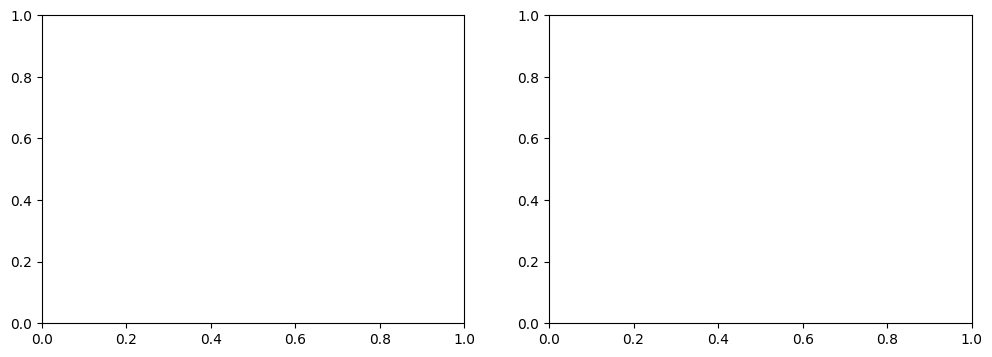

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(range(1, len(recon) + 1), recon)
axes[0].set_title("Reconstruction Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("BCE per image")

axes[1].plot(range(1, len(kl) + 1), kl)
axes[1].set_title("KL Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("nats per image")

plt.tight_layout()
plt.show()

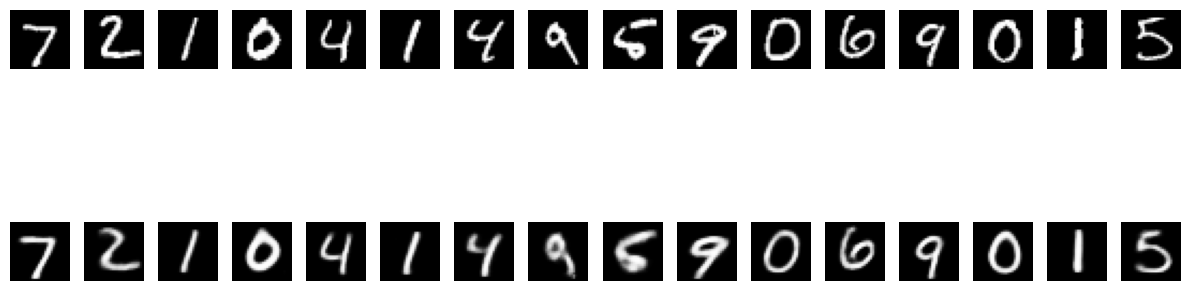

In [14]:
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.to(device).view(-1, 28 * 28)
    recon, _ = model(x)

plt.figure(figsize=(12,6))
for i in range(16):
    plt.subplot(2, 16, i + 1)
    plt.imshow(x[i].cpu().view(28, 28), cmap="gray")
    plt.axis("off")

    plt.subplot(2, 16, i + 17)
    plt.imshow(recon[i].cpu().view(28, 28), cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

Sampling through Gumbel random variable

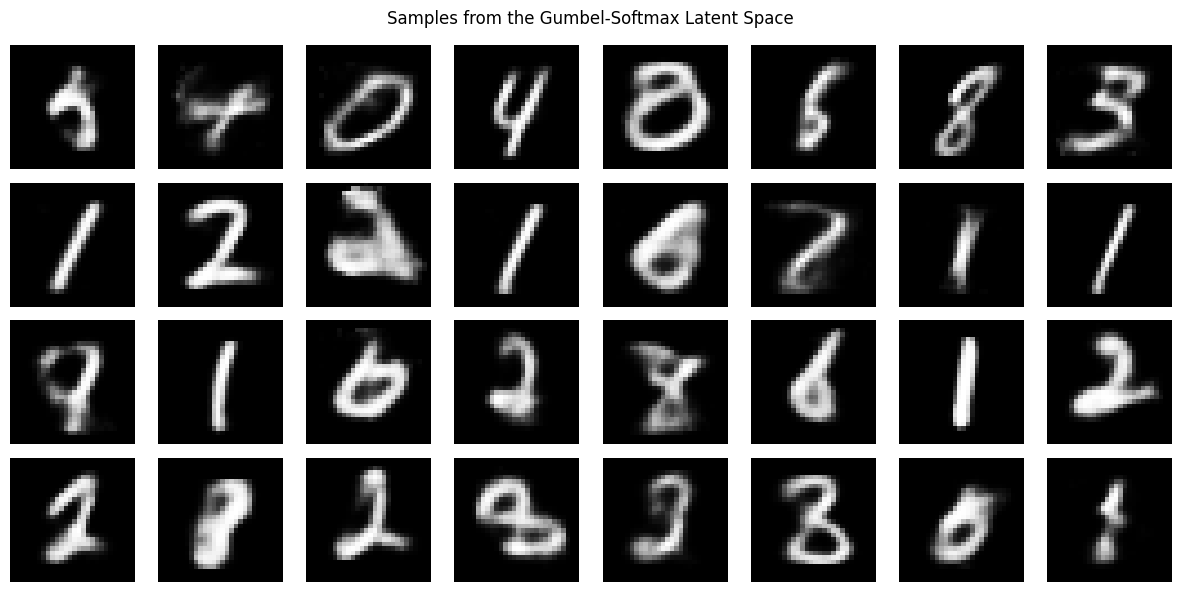

In [21]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

batch_size = 32

tau = 0.5

with torch.no_grad():
    logits = torch.zeros(batch_size * model.num_cats, model.per_cat, device=device)
    z = F.gumbel_softmax(logits, tau=tau, hard=True)
    z = z.view(-1, 20 * 10)
    samples = model.decoder(z)

plt.figure(figsize=(12, 6))
for i in range(batch_size):
    plt.subplot(4, 8, i + 1)
    plt.imshow(samples[i].cpu().view(28, 28), cmap="gray")
    plt.axis("off")
plt.suptitle("Samples from the Gumbel-Softmax Latent Space")
plt.tight_layout()
plt.show()

Direct sampling through one hot encoding

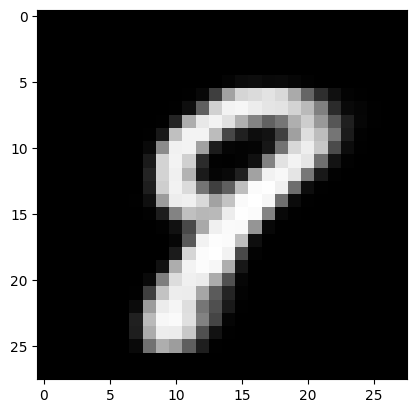

In [35]:
z = F.one_hot(torch.randint(0, 9, (model.num_cats,)), num_classes=model.per_cat) \
    .view(-1, model.num_cats * model.per_cat) \
    .float() \
    .to(device)

with torch.no_grad():
    sample = model.decoder(z)

plt.imshow(sample.cpu().view(28, 28), cmap="gray")

In [36]:
z_ohe = []
z_hards = []
targets = []

for data in train_loader:
    input, target = data
    input = input.view(-1, 28 * 28).to(device)
    _, soft = model(input, tau=1.0)
    hard = soft.view(-1, 20, 10).argmax(-1)
    z_hards.append(hard)
    z_ohe.append(F.one_hot(hard, num_classes=10).view(-1, 20 * 10))
    targets.append(target)

z_ohe = torch.cat(z_ohe, dim=0).cpu()
z_hard = torch.cat(z_hards, dim=0).cpu()
target = torch.cat(targets, dim=0).cpu()

In [37]:
print(target.shape, z_ohe.shape, z_hard.shape)

torch.Size([60000]) torch.Size([60000, 200]) torch.Size([60000, 20])


I thought we'd be able to see patterns off analyzing frequencies of each index that the decoder embeds for images of the same number, but as you see below, it's fairly hard to tell.

In [38]:
from collections import Counter

def visualize_target(ind):
    data = z_hard[target == ind]
    data = data.T

    plt.figure(figsize=(12, 6))
    data = data.numpy()
    for i in range(data.shape[0]):
        plt.subplot(5, 4, i + 1)
        c = Counter(data[i])
        for j in range(10):
            c[j] = max(0, c[j])
        plt.bar(range(10), c.values())
        plt.title(f"Index {i}")

    plt.subplots_adjust(hspace=1.0, wspace=0.4)
    plt.show()

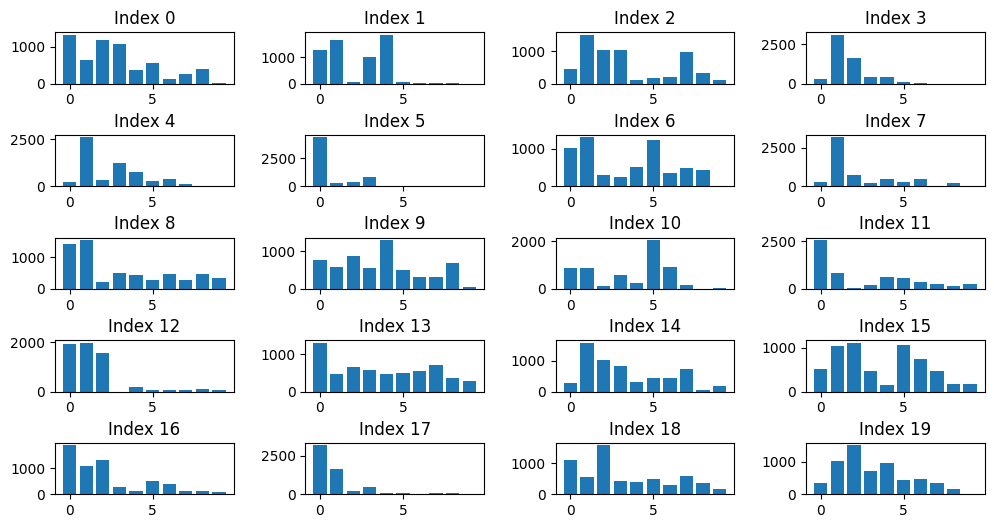

In [39]:
visualize_target(0)

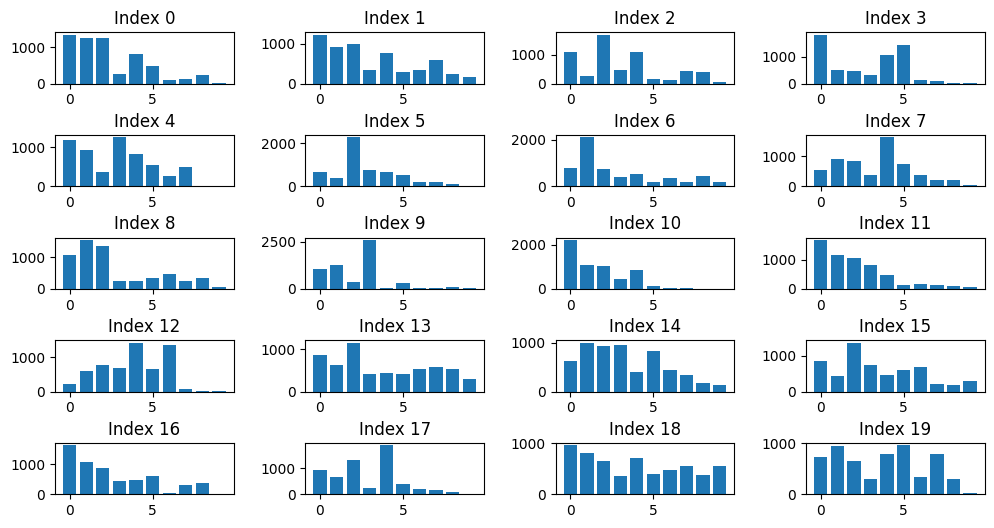

In [40]:
visualize_target(8)

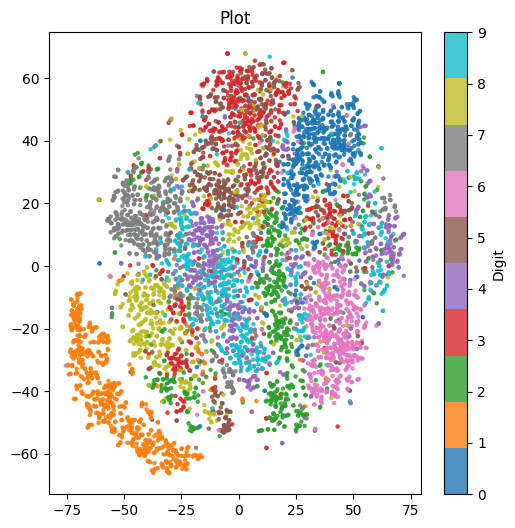

In [45]:
from sklearn.manifold import TSNE

N = 10000

ohe = z_ohe.numpy()[:N]
t = target.numpy()[:N]
tsne = TSNE(n_components=2, perplexity=30, init='pca')
emb = tsne.fit_transform(ohe)

plt.figure(figsize=(6,6))
sc = plt.scatter(emb[:, 0], emb[:, 1],
                 c=t, cmap='tab10', s=5, alpha=0.8)
plt.colorbar(sc, ticks=range(10), label='Digit')
plt.title("Plot")
plt.show()

Decent amount of separation in the tSNE plot as seen above, some clusters could be better though.